In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import math
import time
import os
import random

import sys
sys.path.insert(0,'..')

/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:2


# 1. Load the data and get measurements

In [3]:
ROOT_PATH = "/scratch/cluster/bodeng/UTAFSDataNew/new_data"
CHIP_NUM = 20

In [4]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [6]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (3, 2, 1500)
GT S-parameters shape:  (3, 2, 1500)
Y S-parameters shape:  (3, 2, 62)


In [7]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (1500,)
Y frequencies shape:  (62,)


In [8]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  100000000.0
Mean frequency spacing:  100000000.0
STD frequency spacing:  4.416102007326934e-06
Mode frequency spacing:  100000000.0
Number of samples with non-equal spacing:  126


In [9]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [10]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  1500
N_SPARAMS:  3


In [11]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 6, 1500])


In [12]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 3, 1500])


## Plot some stuff

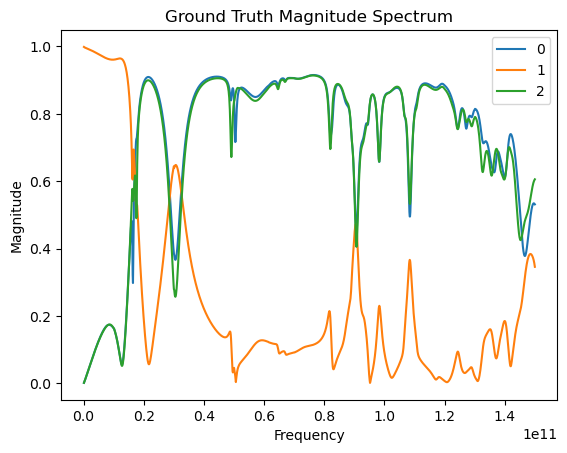

In [13]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

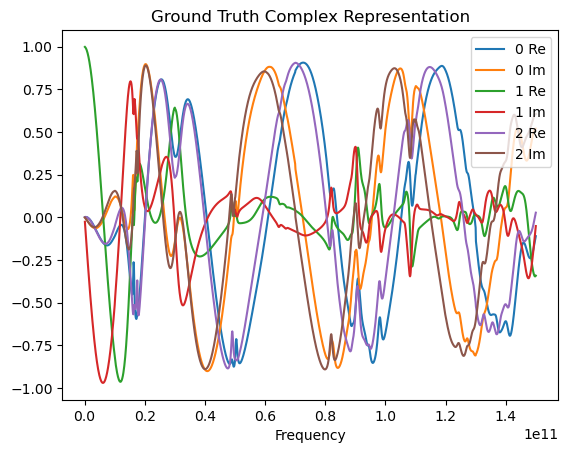

In [14]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [15]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
# M = int(0.10 * N_FREQS)
M = 62

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)
old_kept = kept_inds.copy()

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

# remove every other point, starting at the back, don't remove first point
remove = False
for i in range(len(kept_inds) - 1, 0, -1):
    if remove:
        kept_inds = np.delete(kept_inds, [i])
        remove = False
    else:
        remove = True


print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)
print(kept_inds)
print(old_kept)

Number of Ground Truth Frequency Points:  1500
Number of Measurements:  62
Undersampling Ratio:  0.04133333333333333
[   0   24   73  122  172  221  270  319  368  417  466  516  565  614
  663  712  761  810  860  909  958 1007 1056 1105 1154 1204 1253 1302
 1351 1400 1449 1499]
[   0   24   49   73   98  122  147  172  196  221  245  270  294  319
  344  368  393  417  442  466  491  516  540  565  589  614  638  663
  688  712  737  761  786  810  835  860  884  909  933  958  982 1007
 1032 1056 1081 1105 1130 1154 1179 1204 1228 1253 1277 1302 1326 1351
 1376 1400 1425 1449 1474 1499]


In [16]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 6, 32])
y_freqs shape:  (32,)


# 2. Network Setup

## Define network parameters

In [17]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False
USE_SGLD = False

In [18]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  6
NUM_LAYERS:  7
BASE NGF:  16
NGF:  [16, 16, 16, 16, 16, 16, 16]
BS:  1
NC:  6
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [19]:
from models import RES_UNET

net = RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE,
               p_dropout=0.0
               )
net = net.to(device)

In [20]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


Net output shape:  torch.Size([1, 6, 1500])


In [21]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  26002


# 3. Run

## Define training parameters, losses, and track stats

In [22]:
#grab the correct file we want for VF
NUM_ACTIVE = M - len(kept_inds)

LR = 2e-4
FIRST_ITER = 20000
NUM_ITER = 2000
TOTAL_ITERS = FIRST_ITER + NUM_ITER * NUM_ACTIVE
CURR_ITER = FIRST_ITER

NUM_BURN_ITER = NUM_ITER * 0 # 0.2
SAMPLE_EVERY = 40

ACTIVE_ITER_RATIO = 0.1
SAMPLE_LAST_N = NUM_ITER * ACTIVE_ITER_RATIO

# TODO: maybe come back to this?
# TOTAL_ITER = NUM_ITER + 0.1 * NUM_ACTIVE * NUM_ITER

REG_HYPERPARAM = 1.0
NOISY_INPUT = True
USE_SGLD = False

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
    regularizer = regularizer.to(device)

optim = torch.optim.Adam(net.parameters(), lr=LR)

def get_lr(optim):
    for g in optim.param_groups:
        return g['lr']
    
def set_lr(optim, lr):
    for g in optim.param_groups:
        g['lr'] = lr
        
START_NOISE_LEVEL = CUR_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / TOTAL_ITERS) 

START_LR = LR
END_LR = 1e-5
LR_DECAY_FACTOR = 1 # (END_LR / START_LR)**(1 / NUM_ITER)


train_losses = []
train_errors = []
if REG_HYPERPARAM > 0:
    train_regs = []

test_mses = []
test_maes = []

is_initial_fit = True
tic = time.time()
net.train()

# (NUM_ACTIVE + 1) * NUM_OUTPUTS * S_PARAMS * FREQS
sgld_outputs_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_means_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_stds_by_sample = []

for num_actively_sampled in range(NUM_ACTIVE + 1):

    cur_sgld_outputs = torch.Tensor().to(device)   

    if not is_initial_fit:

        # Find the maximum standard deviation point, and use it to update kept_inds
        max_disagree_idx = find_max_variance(sgld_outputs_by_sample[-1][-1], pickRandom=False)
        kept_inds = np.sort(np.append(kept_inds, max_disagree_idx))
        print(kept_inds)

        # Recreate the y data with the new kept_inds
        y = torch.clone(x)[:, :, kept_inds]
        y_freqs = gt_freqs[kept_inds]

        # Update the LR and noise level based on our decay rates
        set_lr(optim, START_LR * LR_DECAY_FACTOR**((1 - ACTIVE_ITER_RATIO) * NUM_ITER / ACTIVE_ITER_RATIO))
        # CUR_NOISE_LEVEL = START_NOISE_LEVEL * NOISE_DECAY_FACTOR**((1 - ACTIVE_ITER_RATIO) *  NUM_ITER / ACTIVE_ITER_RATIO)

    # Update the criterion to reflect the new point we have sampled
    criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
    criterion = criterion.to(device)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=LR_DECAY_FACTOR)


    for i in range(int(CURR_ITER)):
        optim.zero_grad()
        
        if NOISY_INPUT:
            out = net.forward_with_z(CUR_NOISE_LEVEL)
            CUR_NOISE_LEVEL *= NOISE_DECAY_FACTOR
        else:
            out = net.forward_with_z()
        
        train_error = criterion(out, y) 
        if REG_HYPERPARAM > 0:
            train_reg = REG_HYPERPARAM * regularizer(out)
            train_loss = train_error + train_reg
        else:
            train_loss = train_error
        
        train_loss.backward()
        optim.step()
        scheduler.step()

        with torch.no_grad():
            # First 20% of training will be burn-in iterations
            if (not is_initial_fit or i > NUM_BURN_ITER) and USE_SGLD:
                # Perform SGLD by adding Gaussian noise to parameters after gradient descent
                for param in net.parameters():
                    # param.add_(torch.normal(0, get_lr(optim), size=param.size()).to(device))
                    param.add_(torch.randn_like(param) * get_lr(optim) * 2)
            
            # Log the standard metrics across different numbers of samples given
            train_losses.append(train_loss.item())
            train_errors.append(train_error.item())
            if REG_HYPERPARAM > 0:
                train_regs.append(train_reg.item())
            
            test_mse = nn.MSELoss()(out, x)
            test_mses.append(test_mse.item())
            
            test_mae = nn.L1Loss()(out, x)
            test_maes.append(test_mae.item())

            if (i+1)%1000 == 0 or i == 0:
                toc = time.time()
                print("ITER ", str(i))
                print("TIME: ", str(toc - tic))
                if NOISY_INPUT:
                    print("NOISE LEVEL: ", CUR_NOISE_LEVEL)
                print()

            # Get SGLD outputs for finding mean/std
            if (NUM_ITER - i <= SAMPLE_LAST_N) and i % SAMPLE_EVERY == 0:
                cur_sgld_outputs = torch.cat([cur_sgld_outputs, out])

    sgld_outputs_by_sample.append(cur_sgld_outputs)
    sgld_means_by_sample.append(torch.mean(cur_sgld_outputs, dim=0))
    sgld_stds_by_sample.append(torch.std(cur_sgld_outputs, dim=0))

    if is_initial_fit :
    #     NUM_ITER *= ACTIVE_ITER_RATIO
        CURR_ITER = NUM_ITER
        is_initial_fit = False


    def find_max_variance(outputs, pickRandom=False):
        # Outputs of shape [NUM_OUTPUTS, 20, 1000]

        # Call np.var with dim = 0 to get shape [20, 1000]
        print(x.shape)
        print(outputs.shape)
        abs_differences = torch.square(torch.subtract(x[0], outputs))

        # Sum to go to [1000]
        abs_differences = torch.mean(abs_differences, dim=0)
        print(abs_differences)

        if pickRandom:
            while True:
                rand_idx = random.randint(0, len(abs_differences) - 1)
                if rand_idx not in kept_inds:
                    print("picked: ", rand_idx)
                    return rand_idx

        _, idxs = torch.topk(abs_differences, len(abs_differences))

        for idx in idxs:
            if idx.item() not in kept_inds:
                return idx.item()
        return -1
    
    print("NUM_SAMPLES ", str(num_actively_sampled))
    print("TIME: ", str(toc - tic))


ITER  0
TIME:  70.28830933570862
NOISE LEVEL:  0.9999136567868026

ITER  999
TIME:  98.44550132751465
NOISE LEVEL:  0.9172759353897951

ITER  1999
TIME:  130.44673228263855
NOISE LEVEL:  0.841395141645221

ITER  2999
TIME:  163.73779344558716
NOISE LEVEL:  0.7717915155850473

ITER  3999
TIME:  199.0030460357666
NOISE LEVEL:  0.7079457843841813

ITER  4999
TIME:  233.89399552345276
NOISE LEVEL:  0.6493816315762609

ITER  5999
TIME:  268.2831039428711
NOISE LEVEL:  0.5956621435290617

ITER  6999
TIME:  302.4940004348755
NOISE LEVEL:  0.5463865498819098

ITER  7999
TIME:  335.42571449279785
NOISE LEVEL:  0.5011872336273314

ITER  8999
TIME:  362.562641620636
NOISE LEVEL:  0.4597269885309338

ITER  9999
TIME:  389.8259518146515
NOISE LEVEL:  0.4216965034286451

ITER  10999
TIME:  416.9628915786743
NOISE LEVEL:  0.386812054633115

ITER  11999
TIME:  444.02973318099976
NOISE LEVEL:  0.3548133892336386

ITER  12999
TIME:  472.94402623176575
NOISE LEVEL:  0.32546178349810806

ITER  13999
TIME:

In [23]:
# NUM_FORWARD_PASSES = 100
# sums_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# sums_squared_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# for i in range(NUM_FORWARD_PASSES):
#     sums_forward_pass_outputs += net.forward_with_z().cpu()
#     sums_squared_forward_pass_outputs += torch.square(net.forward_with_z()).cpu()

# mean_forward_pass_outputs = sums_forward_pass_outputs / NUM_FORWARD_PASSES
# std_forward_pass_outputs = torch.sqrt(((NUM_FORWARD_PASSES * sums_squared_forward_pass_outputs) - (sums_forward_pass_outputs * sums_forward_pass_outputs)) / (NUM_FORWARD_PASSES * (NUM_FORWARD_PASSES - 1)))

print(sgld_outputs_by_sample[0].shape)
print(sgld_means_by_sample[0].shape)
print(sgld_stds_by_sample[0].shape)

torch.Size([455, 6, 1500])
torch.Size([6, 1500])
torch.Size([6, 1500])


## Plot metrics and outputs

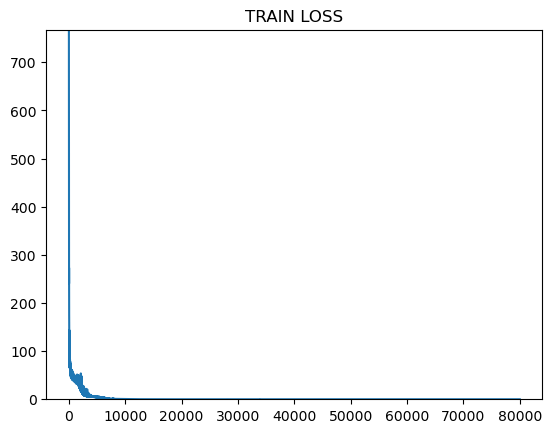

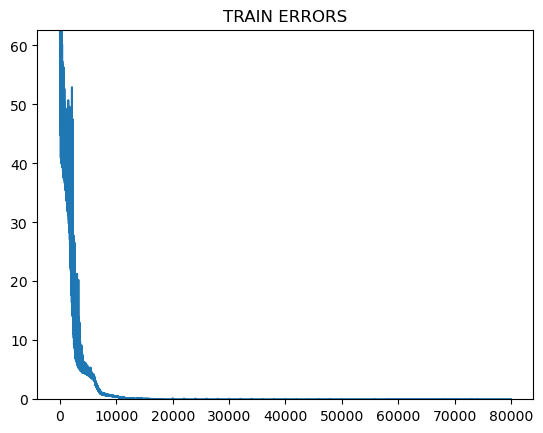

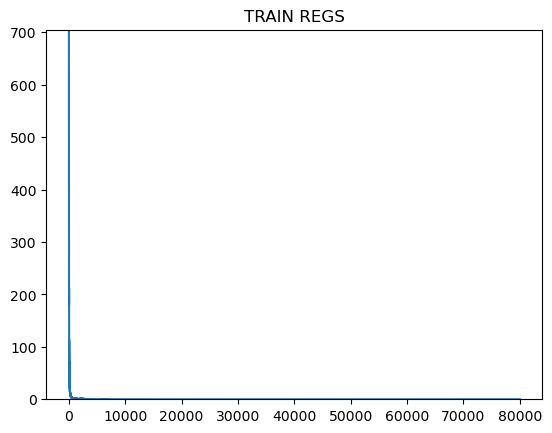

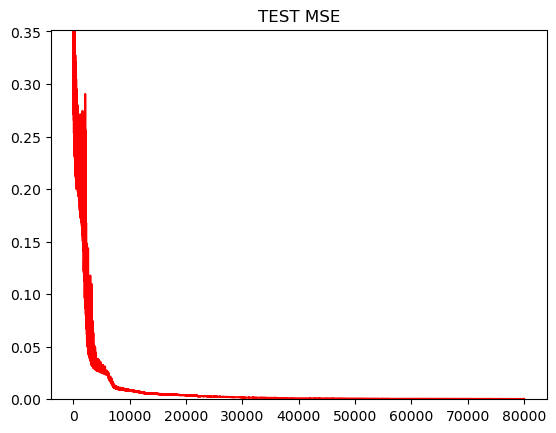

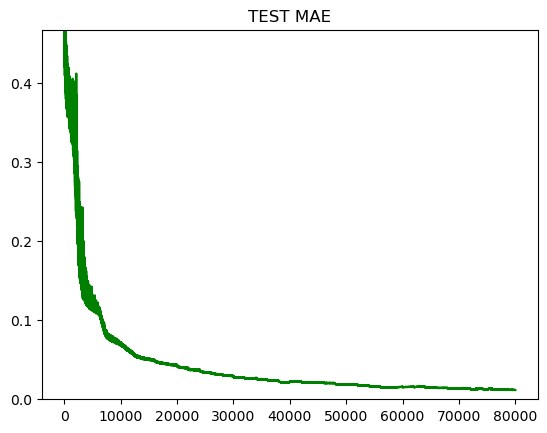

In [24]:
max_idx = 0

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[max_idx])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [25]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  0.00027141027385368943
Best Test MSE:  0.00026523543056100607
Best Test MSE Iteration:  79448


In [26]:
# Make the VF Solution and use it as input to network
import VF.vectorfit
import os

LENGTH = len(gt_freqs)

cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
fname = os.path.join(ROOT_PATH, "case"+cn)

children = os.listdir(fname)
children = [f for f in children if cn + ".s" in f]

final_path = os.path.join(fname, children[0])

print(final_path)

fitter = VF.vectorfit.VectorFitter(final_path)
print(y_freqs)
fit1 = fitter.vector_fit("VF Result", y_freqs) 
vf_output = fit1.fitted_network.s
print(vf_output.shape)
print(vf_output.dtype)
vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
vf_data = utils.matrix_to_sparams(vf_data)
vf_data = torch.tensor(vf_data).view(1, -1, LENGTH)
vf_data = vf_data.to(device)
print(vf_data.shape)

/scratch/cluster/bodeng/UTAFSDataNew/new_data/case20/case20.s2p
[1.000e+08 2.500e+09 7.400e+09 9.700e+09 1.230e+10 1.490e+10 1.620e+10
 1.650e+10 1.730e+10 1.770e+10 1.950e+10 2.030e+10 2.040e+10 2.220e+10
 2.710e+10 2.960e+10 3.200e+10 3.420e+10 3.690e+10 3.930e+10 4.180e+10
 4.420e+10 4.670e+10 4.830e+10 4.910e+10 5.040e+10 5.170e+10 5.660e+10
 5.970e+10 6.150e+10 6.640e+10 7.130e+10 7.620e+10 8.110e+10 8.230e+10
 8.610e+10 8.970e+10 9.100e+10 9.270e+10 9.590e+10 9.820e+10 9.920e+10
 1.008e+11 1.032e+11 1.057e+11 1.073e+11 1.084e+11 1.106e+11 1.155e+11
 1.205e+11 1.238e+11 1.254e+11 1.278e+11 1.303e+11 1.322e+11 1.352e+11
 1.376e+11 1.401e+11 1.426e+11 1.450e+11 1.478e+11 1.500e+11]
Performing fit with 1 poles.
  Fitting took 0.03460700251162052 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 0.048434050753712654 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit w

/u/bodeng/CurveFitting-DIP/oracle_sampling/../VF/vectorfit.py:227: UserWarning: The fitted network is passive, but the vector fit is not passive. Consider running `passivity_enforce()` to enforce passivity before using this model.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fit with 6 poles better than 5 (err 0.1005514874758502 vs 0.4346413503637706)
Performing fit with 6 poles.
  Fitting took 0.04340121150016785 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 7 was not subtantially better than 6 (err 0.10455391082090482 vs 0.1005514874758502)
Performing fit with 7 poles.
  Fitting took 0.03990388102829456 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 8 was not subtantially better than 6 (err 0.1132907170750201 vs 0.1005514874758502)
Performing fit with 8 poles.
  Fitting took 0.2989710792899132 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 9 was not subtantially better than 6 (err 0.1278969291986444 vs 0.1005514874758502)
Fit completed in 0.9001955986022949, using 8, resulting in a fit with 6 and error=0.1005514874758502 vs samples and error=0.11630018179022905 vs ground truth.
(1500, 2, 2)
complex128
torch

In [27]:
## Make neworks from DIP, Interp, and Observations
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
VF_MATRIX = utils.sparams_to_matrix(vf_data)
Y_MATRIX = utils.sparams_to_matrix(y)

print(DIP_OUT_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(CHIP_NUM))

DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

print(DIP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
vf_data_mat = utils.matrix_to_sparams(VF_FINAL_OUT)

print(dip_data.shape)
print(vf_data_mat.shape)
print(dip_data.dtype)
print(vf_data_mat.dtype)

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_data_mat)
print("DIP PSNR:      ", psnr_ours)
print("VF PSNR:       ", psnr_vf)

print("Final DIP MSE: ", test_mses[-1])
print("VF MSE:        ", nn.MSELoss()(vf_data, x).item())
print("Mean DIP MSE: ", nn.MSELoss()(sgld_means_by_sample[-1][np.newaxis], x).item())

torch.Size([1500, 2, 2, 2])
torch.Size([1500, 2, 2, 2])
torch.Size([62, 2, 2, 2])
(1500, 2, 2, 2)
(1500, 2, 2, 2)
(3, 2, 1500)
(3, 2, 1500)
float32
float32
DIP PSNR:       41.68433691039092
VF PSNR:        26.011868282745883
Final DIP MSE:  0.00027141027385368943
VF MSE:         0.010020125657320023
Mean DIP MSE:  0.0002715605078265071


(1500,)
torch.Size([6, 1500])
torch.Size([1, 6, 1500])
torch.Size([1, 6, 62])
torch.Size([1, 6, 1500])
torch.Size([1, 6, 1500])


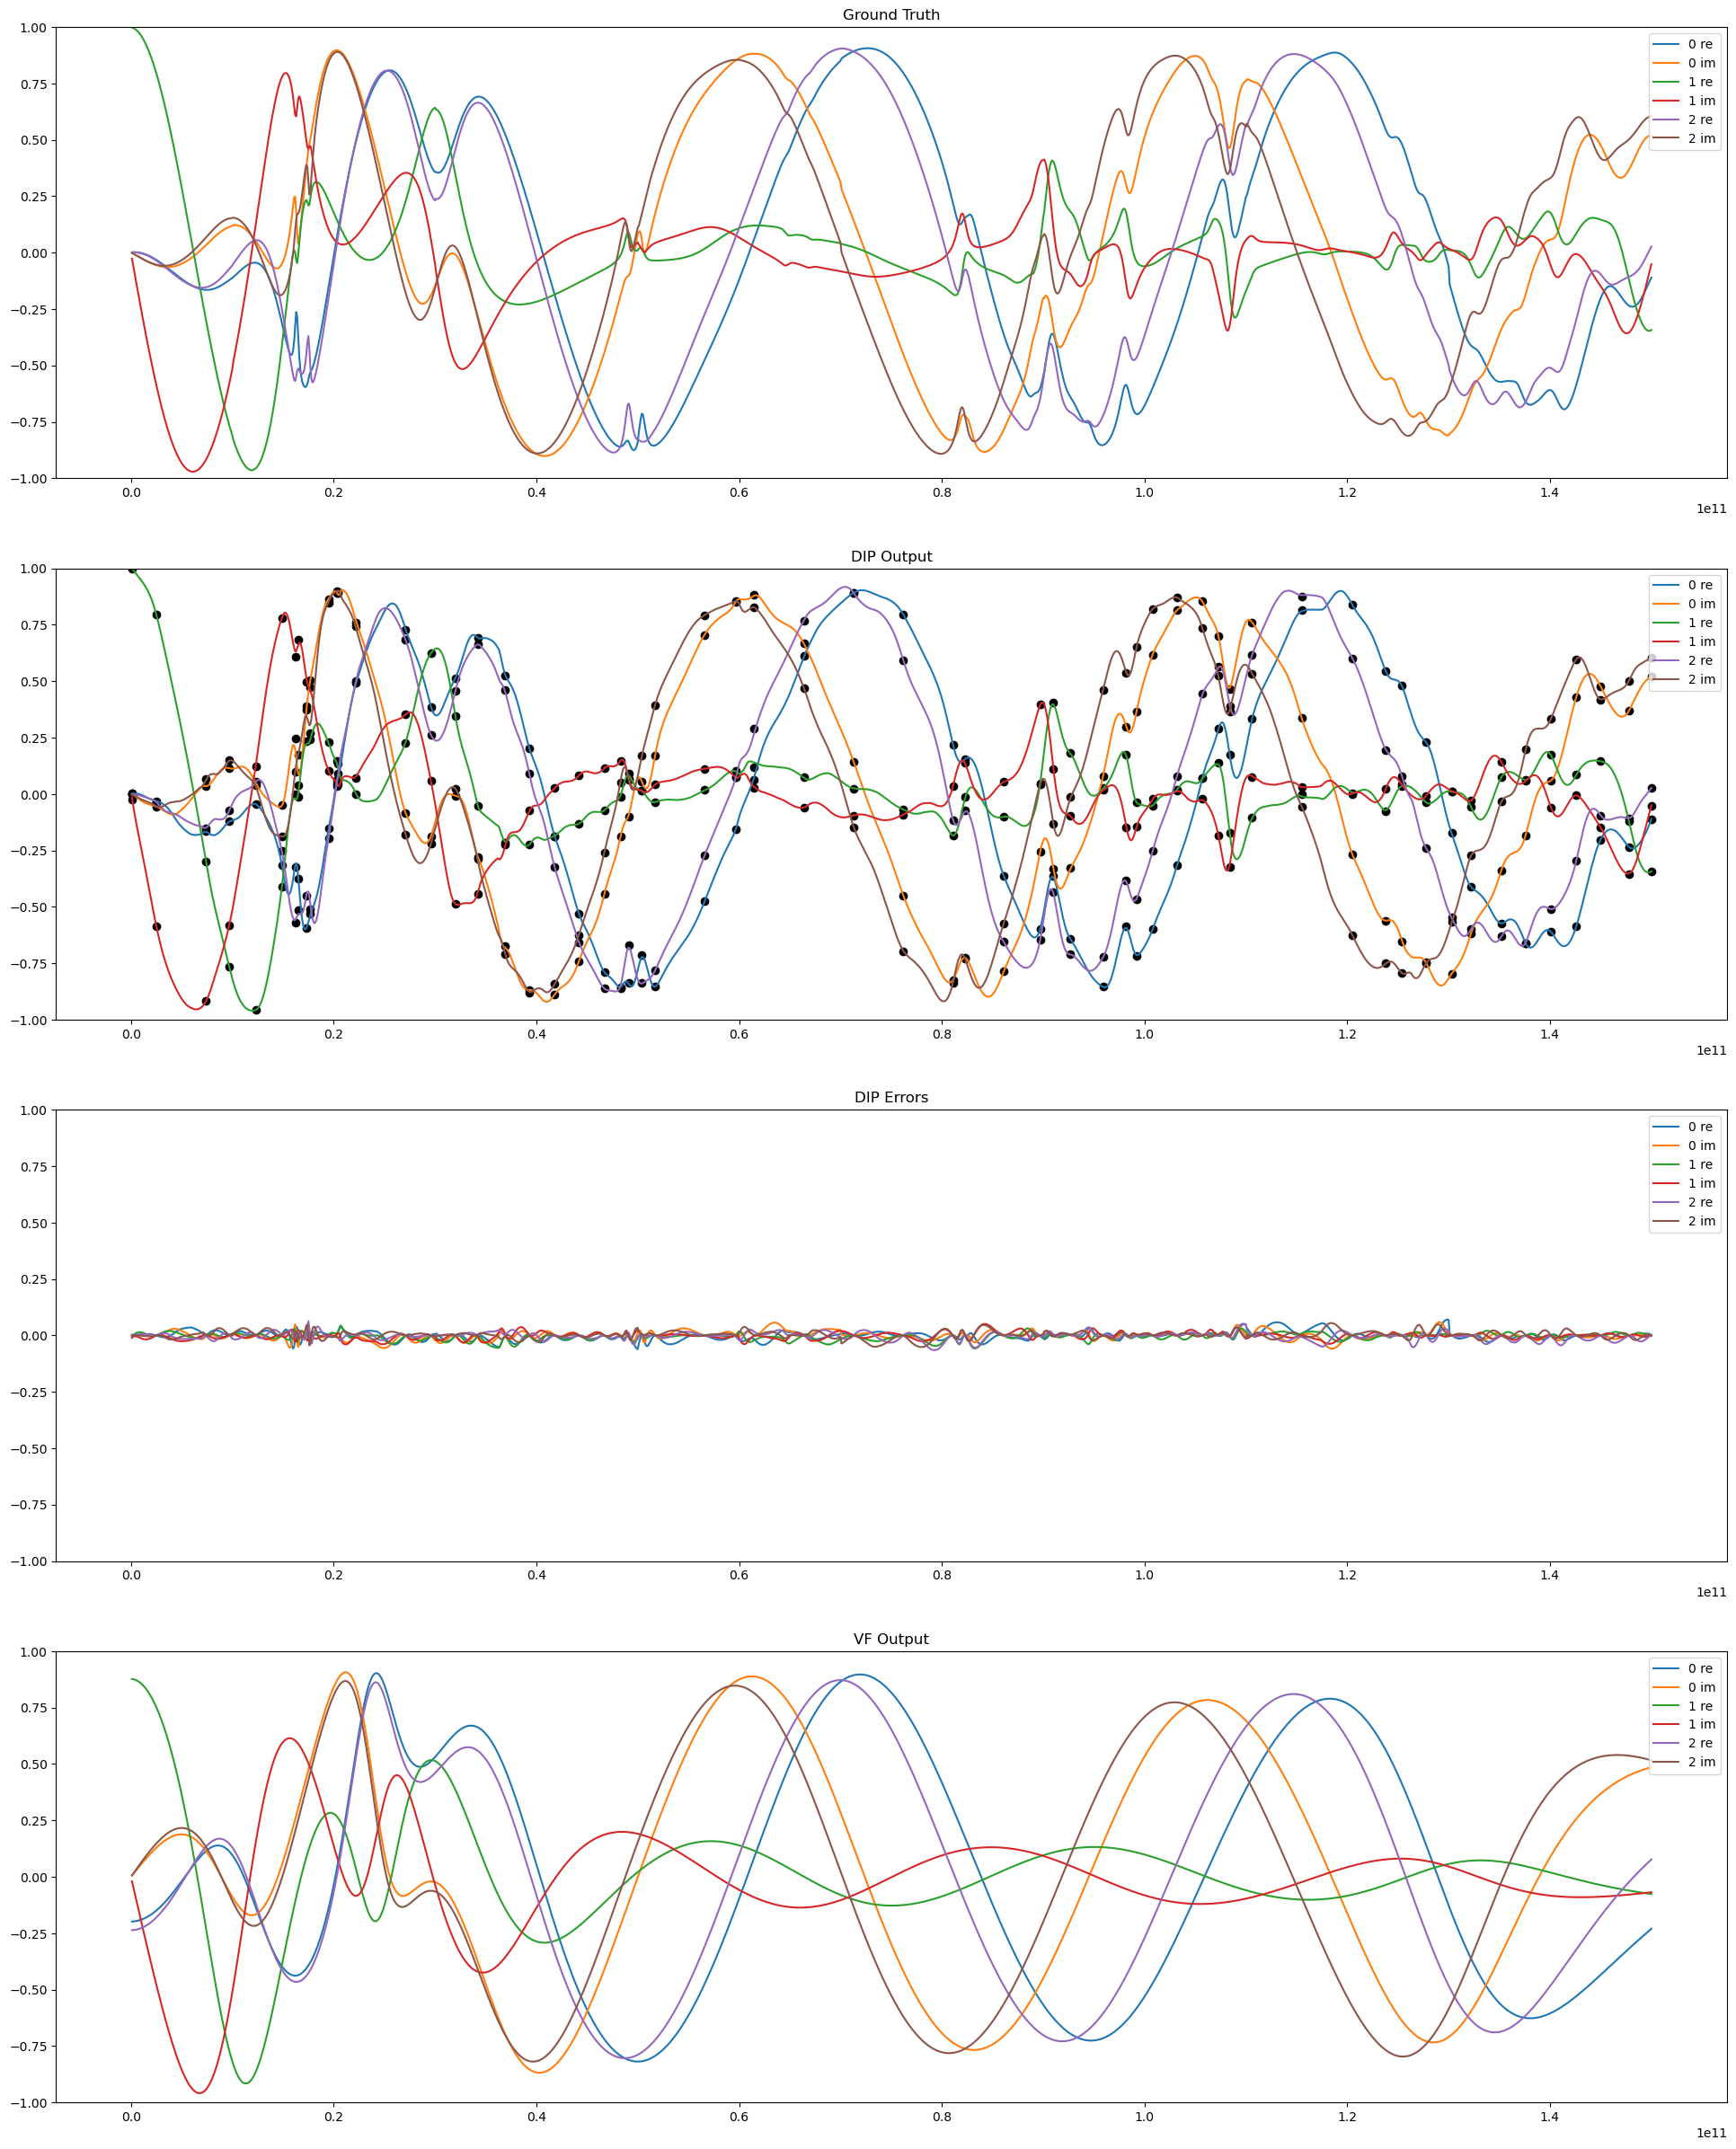

In [28]:
dip_errors = x.detach().cpu() - sgld_means_by_sample[-1].detach().cpu()
print(gt_freqs.shape)
print(sgld_means_by_sample[-1].shape)
print(dip_errors.shape)
print(y.shape)

print(out.shape)
print(vf_data.shape)

fig, axes = plt.subplots(4,1, figsize=(24, 30))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend(loc='upper right')

# SHOW WITH MEAN AND STD DEVS
# for i in range(N_SPARAMS):

#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu(), label=str(i)+" re")
#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu(), label=str(i)+" im")
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i].detach().cpu(), sgld_means_by_sample[-1][2*i].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i].detach().cpu())
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu(), sgld_means_by_sample[-1][2*i+1].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu())

#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')


# axes[1].set_title("DIP Output")
# axes[1].set_ylim(-1,1)
# if N_SPARAMS <= 10:
#     axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")

    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')
axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[3].plot(gt_freqs, vf_data[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[3].plot(gt_freqs, vf_data[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[3].set_title("VF Output")
axes[3].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[3].legend(loc='upper right')

In [29]:
torch.set_printoptions(threshold=100000)
print(sgld_stds_by_sample[-1])

tensor([[4.8438e-05, 4.6377e-05, 4.2638e-05, 4.1646e-05, 4.2808e-05, 2.7883e-04,
         4.4683e-04, 4.6742e-04, 4.7605e-04, 4.7117e-04, 4.5394e-04, 4.4716e-04,
         4.5164e-04, 4.5367e-04, 4.5149e-04, 4.0696e-04, 3.7686e-04, 3.4150e-04,
         3.0166e-04, 5.3297e-04, 5.9923e-04, 5.7998e-04, 5.7382e-04, 5.5376e-04,
         5.2339e-04, 5.1357e-04, 5.3753e-04, 5.8140e-04, 6.3862e-04, 6.8447e-04,
         7.1203e-04, 7.2640e-04, 7.2614e-04, 7.0841e-04, 6.7877e-04, 6.2996e-04,
         5.7251e-04, 5.5128e-04, 5.5289e-04, 7.5418e-04, 7.5130e-04, 7.5725e-04,
         7.5844e-04, 7.7254e-04, 8.0949e-04, 7.7635e-04, 6.9477e-04, 3.3593e-04,
         3.5810e-04, 3.7151e-04, 3.7692e-04, 3.6281e-04, 3.2583e-04, 3.1165e-04,
         3.0810e-04, 3.0648e-04, 2.9944e-04, 2.7371e-04, 2.3627e-04, 2.9343e-04,
         3.4670e-04, 3.5982e-04, 3.4844e-04, 3.3111e-04, 3.2513e-04, 3.4363e-04,
         2.7765e-04, 3.0702e-04, 2.6302e-04, 2.0157e-04, 1.3517e-04, 1.0002e-04,
         1.6576e-04, 1.9776e

In [30]:
print(dip_errors[-1])

tensor([[-1.3545e-03, -9.4172e-04, -4.8773e-04, -3.1592e-04, -4.8827e-04,
         -6.8472e-04, -5.2113e-04, -1.1233e-04,  4.3798e-04,  1.0580e-03,
          1.7546e-03,  2.5915e-03,  3.5734e-03,  4.4478e-03,  5.2177e-03,
          5.7877e-03,  6.1478e-03,  6.2069e-03,  5.9676e-03,  5.3110e-03,
          4.3890e-03,  3.3415e-03,  2.2436e-03,  1.0372e-03, -2.7293e-04,
         -1.7124e-03, -3.2762e-03, -4.6791e-03, -5.9156e-03, -6.8836e-03,
         -7.5771e-03, -7.9917e-03, -8.1206e-03, -7.8516e-03, -7.2126e-03,
         -6.1133e-03, -4.5469e-03, -2.6131e-03, -3.0509e-04,  2.2321e-03,
          5.0251e-03,  8.0768e-03,  1.1394e-02,  1.4718e-02,  1.8056e-02,
          2.1133e-02,  2.3842e-02,  2.5961e-02,  2.7611e-02,  2.9004e-02,
          3.0093e-02,  3.1146e-02,  3.2235e-02,  3.3149e-02,  3.3908e-02,
          3.4475e-02,  3.4973e-02,  3.5231e-02,  3.5247e-02,  3.4450e-02,
          3.3048e-02,  3.1457e-02,  2.9719e-02,  2.7765e-02,  2.5647e-02,
          2.3309e-02,  2.0966e-02,  1.

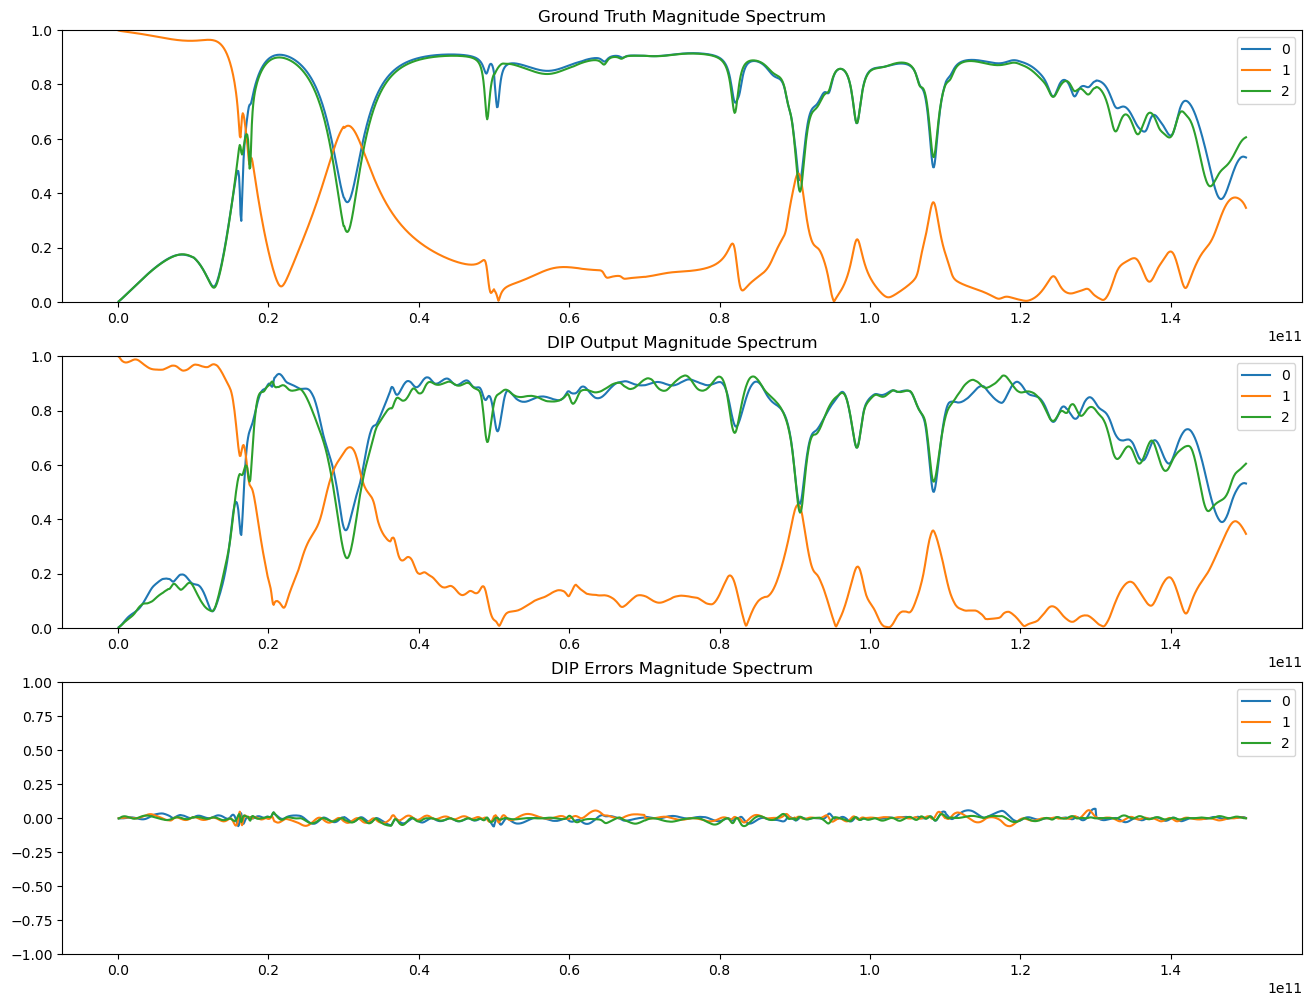

In [31]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

In [32]:
print(kept_inds)

[   0   24   73   96  122  148  161  164  172  176  194  202  203  221
  270  295  319  341  368  392  417  441  466  482  490  503  516  565
  596  614  663  712  761  810  822  860  896  909  926  958  981  991
 1007 1031 1056 1072 1083 1105 1154 1204 1237 1253 1277 1302 1321 1351
 1375 1400 1425 1449 1477 1499]
